In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Propose(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Propose(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    initializer = importance.Propose(init_bouncing_ball, init_proposal)
    
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    step = importance.Propose(bouncing_ball_step, step_proposal)
    
    return foldable.reduce(foldable.Step(step, initializer=initializer), lambda: range(T))

11/24/2019 17:20:20 ELBO=-4.36162811e+02 at epoch 1
11/24/2019 17:20:21 ELBO=-3.77022705e+02 at epoch 2
11/24/2019 17:20:21 ELBO=-4.44904358e+02 at epoch 3
11/24/2019 17:20:22 ELBO=-4.30191193e+02 at epoch 4
11/24/2019 17:20:22 ELBO=-4.36552216e+02 at epoch 5
11/24/2019 17:20:22 ELBO=-2.24304489e+02 at epoch 6
11/24/2019 17:20:23 ELBO=-2.75650024e+02 at epoch 7
11/24/2019 17:20:23 ELBO=-4.08630829e+02 at epoch 8
11/24/2019 17:20:24 ELBO=-3.40546722e+02 at epoch 9
11/24/2019 17:20:24 ELBO=-4.27041199e+02 at epoch 10
11/24/2019 17:20:25 ELBO=-3.49852692e+02 at epoch 11
11/24/2019 17:20:25 ELBO=-4.37678223e+02 at epoch 12
11/24/2019 17:20:26 ELBO=-2.22165344e+02 at epoch 13
11/24/2019 17:20:26 ELBO=-3.04632843e+02 at epoch 14
11/24/2019 17:20:26 ELBO=-4.17484558e+02 at epoch 15
11/24/2019 17:20:27 ELBO=-4.06849823e+02 at epoch 16
11/24/2019 17:20:27 ELBO=-3.92731262e+02 at epoch 17
11/24/2019 17:20:28 ELBO=-3.98551086e+02 at epoch 18
11/24/2019 17:20:28 ELBO=-4.00270996e+02 at epoch 19
11

Epoch   649: reducing learning rate of group 0 to 5.0000e-02.


11/24/2019 17:25:07 ELBO=-1.48072052e+02 at epoch 651
11/24/2019 17:25:08 ELBO=-6.53767242e+01 at epoch 652
11/24/2019 17:25:08 ELBO=-1.46957916e+02 at epoch 653
11/24/2019 17:25:08 ELBO=-1.37086609e+02 at epoch 654
11/24/2019 17:25:09 ELBO=-8.47508926e+01 at epoch 655
11/24/2019 17:25:09 ELBO=-1.21458412e+02 at epoch 656
11/24/2019 17:25:10 ELBO=-7.96545410e+01 at epoch 657
11/24/2019 17:25:10 ELBO=-1.28484818e+02 at epoch 658
11/24/2019 17:25:11 ELBO=-1.32758926e+02 at epoch 659
11/24/2019 17:25:11 ELBO=-1.36081390e+02 at epoch 660
11/24/2019 17:25:11 ELBO=-1.25289688e+02 at epoch 661
11/24/2019 17:25:12 ELBO=-1.26371658e+02 at epoch 662
11/24/2019 17:25:12 ELBO=-9.72375183e+01 at epoch 663
11/24/2019 17:25:13 ELBO=-1.01599442e+02 at epoch 664
11/24/2019 17:25:13 ELBO=-5.22122536e+01 at epoch 665
11/24/2019 17:25:14 ELBO=-1.06976395e+02 at epoch 666
11/24/2019 17:25:14 ELBO=-1.23269852e+02 at epoch 667
11/24/2019 17:25:14 ELBO=-8.39277954e+01 at epoch 668
11/24/2019 17:25:15 ELBO=-1.

Epoch   783: reducing learning rate of group 0 to 2.5000e-02.


11/24/2019 17:26:07 ELBO=-6.39115715e+01 at epoch 785
11/24/2019 17:26:08 ELBO=-1.15267921e+02 at epoch 786
11/24/2019 17:26:08 ELBO=-5.94325027e+01 at epoch 787
11/24/2019 17:26:09 ELBO=-7.75691986e+01 at epoch 788
11/24/2019 17:26:09 ELBO=-6.65875473e+01 at epoch 789
11/24/2019 17:26:10 ELBO=-1.21958267e+02 at epoch 790
11/24/2019 17:26:10 ELBO=-1.05766930e+02 at epoch 791
11/24/2019 17:26:10 ELBO=-1.17423584e+02 at epoch 792
11/24/2019 17:26:11 ELBO=-1.14962227e+02 at epoch 793
11/24/2019 17:26:11 ELBO=-9.00942535e+01 at epoch 794
11/24/2019 17:26:12 ELBO=-9.45895386e+01 at epoch 795
11/24/2019 17:26:12 ELBO=-1.07204468e+02 at epoch 796
11/24/2019 17:26:13 ELBO=-8.04293976e+01 at epoch 797
11/24/2019 17:26:13 ELBO=-1.14215401e+02 at epoch 798
11/24/2019 17:26:14 ELBO=-8.55044708e+01 at epoch 799
11/24/2019 17:26:14 ELBO=-7.86036530e+01 at epoch 800
11/24/2019 17:26:15 ELBO=-1.09511826e+02 at epoch 801
11/24/2019 17:26:15 ELBO=-1.12263992e+02 at epoch 802
11/24/2019 17:26:15 ELBO=-7.

Epoch   884: reducing learning rate of group 0 to 1.2500e-02.


11/24/2019 17:26:53 ELBO=-1.13452881e+02 at epoch 886
11/24/2019 17:26:53 ELBO=-1.08003922e+02 at epoch 887
11/24/2019 17:26:54 ELBO=-3.94490547e+01 at epoch 888
11/24/2019 17:26:54 ELBO=-9.16033096e+01 at epoch 889
11/24/2019 17:26:55 ELBO=-3.02673035e+01 at epoch 890
11/24/2019 17:26:55 ELBO=-1.12402527e+02 at epoch 891
11/24/2019 17:26:56 ELBO=-1.02635025e+02 at epoch 892
11/24/2019 17:26:56 ELBO=-6.10054855e+01 at epoch 893
11/24/2019 17:26:56 ELBO=-1.03719551e+02 at epoch 894
11/24/2019 17:26:57 ELBO=-8.33651505e+01 at epoch 895
11/24/2019 17:26:57 ELBO=-1.00491226e+02 at epoch 896
11/24/2019 17:26:58 ELBO=-9.14470596e+01 at epoch 897
11/24/2019 17:26:58 ELBO=-5.54561043e+01 at epoch 898
11/24/2019 17:26:59 ELBO=-5.51329498e+01 at epoch 899
11/24/2019 17:26:59 ELBO=-5.21778488e+01 at epoch 900
11/24/2019 17:27:00 ELBO=-6.48610916e+01 at epoch 901
11/24/2019 17:27:00 ELBO=-1.04605377e+02 at epoch 902
11/24/2019 17:27:01 ELBO=-3.05856762e+01 at epoch 903
11/24/2019 17:27:01 ELBO=-1.

Epoch   985: reducing learning rate of group 0 to 6.2500e-03.


11/24/2019 17:27:39 ELBO=-6.73678284e+01 at epoch 987
11/24/2019 17:27:39 ELBO=-1.10240990e+02 at epoch 988
11/24/2019 17:27:40 ELBO=-9.94924240e+01 at epoch 989
11/24/2019 17:27:40 ELBO=-6.24522324e+01 at epoch 990
11/24/2019 17:27:41 ELBO=-1.01978905e+02 at epoch 991
11/24/2019 17:27:41 ELBO=-1.05784050e+02 at epoch 992
11/24/2019 17:27:41 ELBO=-5.39297905e+01 at epoch 993
11/24/2019 17:27:42 ELBO=-8.27041473e+01 at epoch 994
11/24/2019 17:27:42 ELBO=-6.41247482e+01 at epoch 995
11/24/2019 17:27:43 ELBO=-9.01410217e+01 at epoch 996
11/24/2019 17:27:43 ELBO=-9.60662537e+01 at epoch 997
11/24/2019 17:27:44 ELBO=-8.11910172e+01 at epoch 998
11/24/2019 17:27:44 ELBO=-9.96381760e+01 at epoch 999
11/24/2019 17:27:44 ELBO=-8.17608795e+01 at epoch 1000


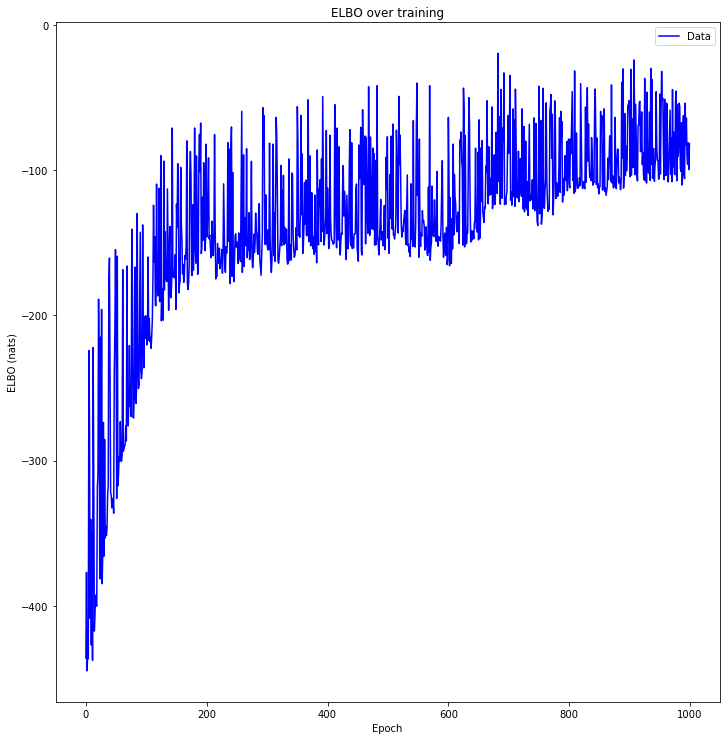

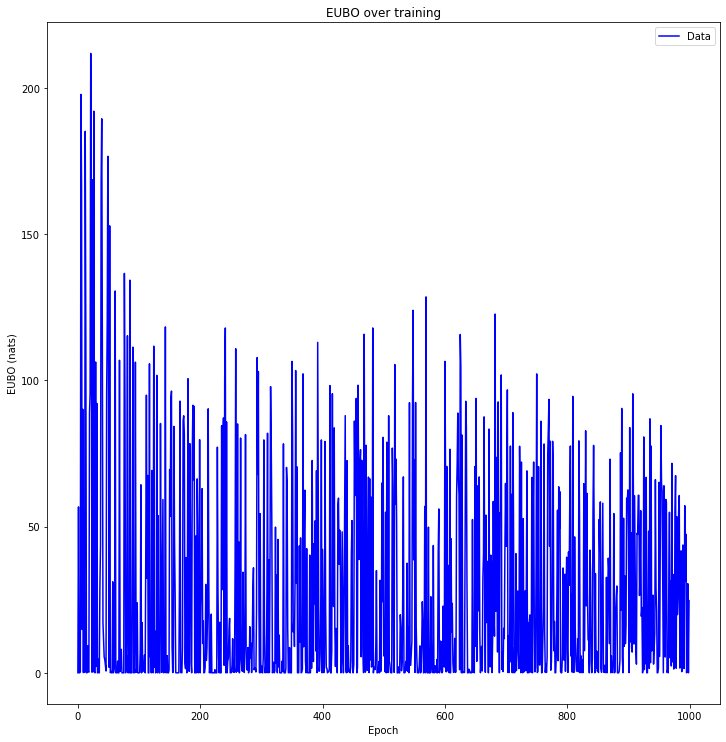

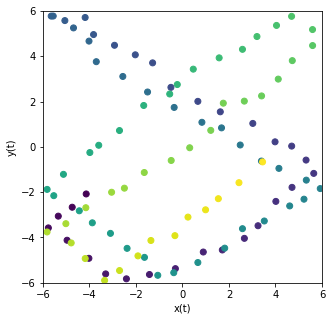

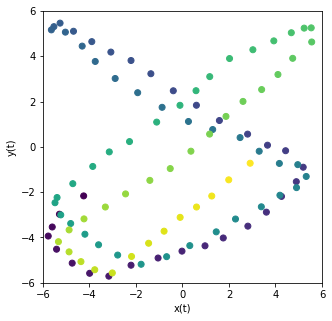

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, (elbos, eubos) = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=True, lr=1e-1, bound='elbo',
        patience=100, log_estimator=True,
    )
    utils.plot_evidence_bounds(elbos.detach().numpy(), True)
    utils.plot_evidence_bounds(eubos.detach().numpy(), False)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=1)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.5007, -1.6102], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.3504, -2.3507], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.3915,  0.0000],\n        [ 0.0315, -1.5654]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-3.9398, -2.1166], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-0.9261, -1.1432], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.3235, -2.3417], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[-0.5480, -0.4809],\n        [-0.2572, -0.5147],\n        [ 0.5898, -0.5873],\n        [ 0.8087, -0.6784],\n        [ 0.7828, -0.6079],\n        [ 0.9231, -0.2471],\n        [ 0.9661,  0.2317],\n        [ 1.0649,  0.3262],\n        [ 1.1147,  0.5135],\n        [ 0.8769,  0.2811],\n        [ 0.9114,  0.5124],\n        [ 0.7263,  0.6050],\n        [ 0.6735,  0.8187],\n        [ 0.7616,  0.6951],\n        [ 0.9372,  0.6398],\n        [ 0.8496,  0.5615],\n        [-0.7332,  0.5712],\n

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([-4.1400, -2.0773])
Inferred position at time 0 tensor([-4.2490, -2.1635])
MSE at time 0 tensor(0.0193)
Position at time 1 tensor([-4.7412, -2.6636])
Inferred position at time 1 tensor([-5.2913, -2.9721])
MSE at time 1 tensor(0.3978)
Position at time 2 tensor([-5.3402, -3.0572])
Inferred position at time 2 tensor([-5.5999, -3.5361])
MSE at time 2 tensor(0.2968)
Position at time 3 tensor([-5.7674, -3.5761])
Inferred position at time 3 tensor([-5.7726, -3.9361])
MSE at time 3 tensor(0.1296)
Position at time 4 tensor([-4.9624, -4.1209])
Inferred position at time 4 tensor([-5.4147, -4.5171])
MSE at time 4 tensor(0.3615)
Position at time 5 tensor([-4.0238, -4.9189])
Inferred position at time 5 tensor([-4.7420, -5.1319])
MSE at time 5 tensor(0.5613)
Position at time 6 tensor([-3.3023, -5.6069])
Inferred position at time 6 tensor([-3.9919, -5.5804])
MSE at time 6 tensor(0.4762)
Position at time 7 tensor([-2.4100, -5.8248])
Inferred position at time 7 tensor([-3.1653,

In [24]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Inferred position at time 0 tensor([-3.5230, -1.8644])
MSE at time 0 tensor(0.4259)
Inferred position at time 1 tensor([-4.6586, -2.7931])
MSE at time 1 tensor(0.0236)
Inferred position at time 2 tensor([-5.1548, -3.2103])
MSE at time 2 tensor(0.0578)
Inferred position at time 3 tensor([-5.4371, -3.6553])
MSE at time 3 tensor(0.1153)
Inferred position at time 4 tensor([-5.1702, -4.3045])
MSE at time 4 tensor(0.0769)
Inferred position at time 5 tensor([-4.5645, -4.9722])
MSE at time 5 tensor(0.2953)
Inferred position at time 6 tensor([-3.7763, -5.4924])
MSE at time 6 tensor(0.2377)
Inferred position at time 7 tensor([-3.1877, -5.5221])
MSE at time 7 tensor(0.6964)
Inferred position at time 8 tensor([-2.5518, -4.4726])
MSE at time 8 tensor(2.6304)
Inferred position at time 9 tensor([-1.7149, -3.8591])
MSE at time 9 tensor(4.2889)
Inferred position at time 10 tensor([-0.6611, -3.4478])
MSE at time 10 tensor(3.8499)
Inferred position at time 11 tensor([ 0.4887, -3.0836])
MSE at time 11 ten

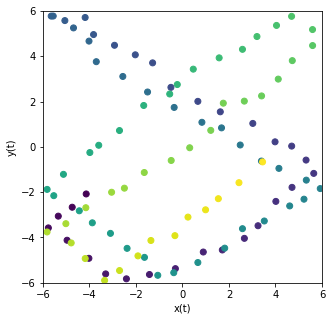

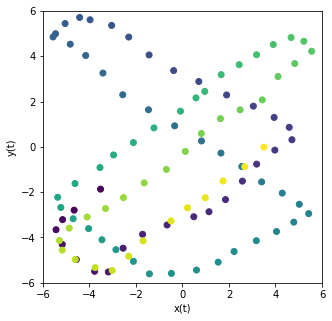

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)